# Forecast-Aware Strategy Analysis

This notebook analyzes the forecast-aware scheduling strategy's behavior across different carbon intensity levels.

The forecast-aware strategy uses carbon intensity predictions to proactively adjust traffic distribution.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import glob
import os

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load Data

In [12]:
# Find the most recent forecast-aware results
result_dirs = glob.glob('results/simple_20251118_184912/forecast-aware')
if not result_dirs:
    raise FileNotFoundError("No forecast-aware results found. Run the benchmark first.")

latest_dir = max(result_dirs, key=os.path.getmtime)
csv_path = os.path.join(latest_dir, 'timeseries.csv')
print(f"Loading data from: {csv_path}")

# Load timeseries data
df = pd.read_csv(csv_path)

# Calculate percentages
df['total_requests'] = df['requests_precision_30'] + df['requests_precision_50'] + df['requests_precision_100']
df['p30_pct'] = (df['requests_precision_30'] / df['total_requests']) * 100
df['p50_pct'] = (df['requests_precision_50'] / df['total_requests']) * 100
df['p100_pct'] = (df['requests_precision_100'] / df['total_requests']) * 100

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Total samples: {len(df)}")
print(f"Duration: {df['elapsed_seconds'].max():.1f} seconds")
print(f"Total requests: {df['total_requests'].sum():.0f}")
df.head()

Loading data from: results/simple_20251118_184912/forecast-aware/timeseries.csv
Total samples: 119
Duration: 604.2 seconds
Total requests: 330238


,timestamp,elapsed_seconds,delta_requests,mean_precision,credit_balance,credit_velocity,engine_avg_precision,carbon_now,carbon_next,requests_precision_30,...,replicas_consumer,replicas_target,ceiling_router,ceiling_consumer,ceiling_target,throttle_factor,total_requests,p30_pct,p50_pct,p100_pct
0,2025-11-18 18:50:40.124406+00:00,5.0,1620,0.9001,0.6113,0.0764,0.9055,65.0,70.0,157,...,0,0,NaN,NaN,NaN,0.0,1620,9.691358,6.419753,83.888889
1,2025-11-18 18:50:45.194847+00:00,10.1,2658,0.9422,0.6903,0.0767,0.9396,70.0,80.0,138,...,0,0,NaN,NaN,NaN,0.0,2658,5.191874,4.288939,90.519187
2,2025-11-18 18:50:50.255605+00:00,15.1,2417,0.9307,0.8414,0.0756,0.9253,70.0,80.0,167,...,0,0,NaN,NaN,NaN,0.0,2417,6.909392,4.178734,88.911874
3,2025-11-18 18:50:55.380471+00:00,20.2,2181,0.9291,0.9135,0.0745,0.9185,70.0,80.0,136,...,0,0,NaN,NaN,NaN,0.0,2181,6.235672,5.456213,88.308116
4,2025-11-18 18:51:00.460806+00:00,25.3,2594,0.9652,1.0000,0.0756,0.9765,80.0,120.0,76,...,0,0,NaN,NaN,NaN,0.0,2594,2.929838,2.852737,94.217425


## 2. Carbon Intensity Distribution

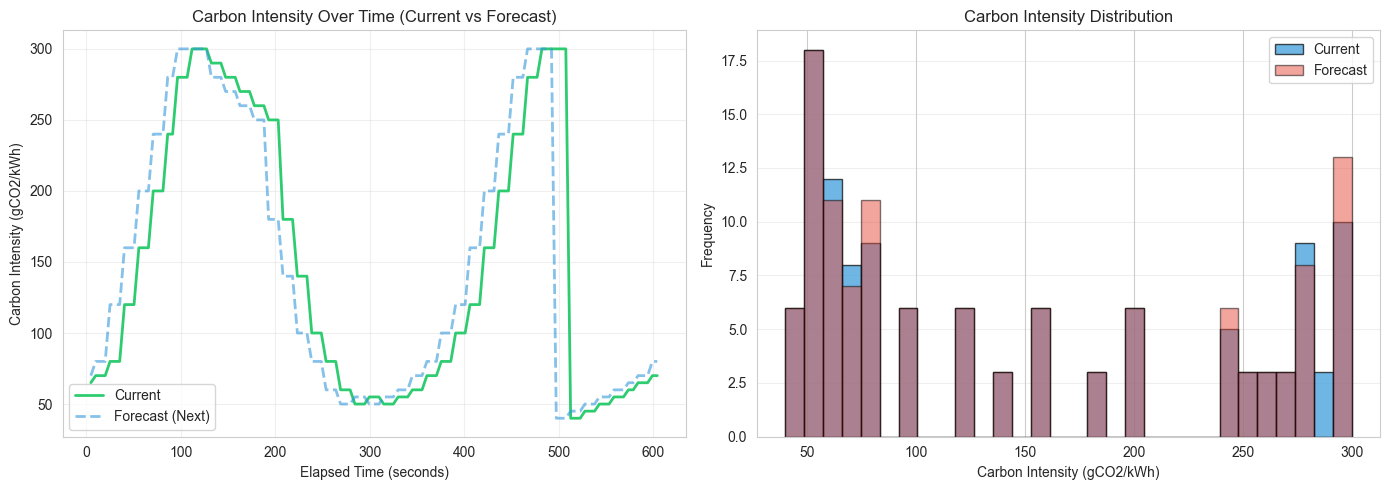

Current carbon intensity range: 40 - 300 gCO2/kWh
Mean current carbon intensity: 147.8 gCO2/kWh
Forecast carbon intensity range: 40 - 300 gCO2/kWh
Mean forecast carbon intensity: 147.9 gCO2/kWh


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series of carbon intensity (current and forecast)
axes[0].plot(df['elapsed_seconds'], df['carbon_now'], linewidth=2, color='#2ecc71', label='Current')
axes[0].plot(df['elapsed_seconds'], df['carbon_next'], linewidth=2, color='#3498db', alpha=0.6, linestyle='--', label='Forecast (Next)')
axes[0].set_xlabel('Elapsed Time (seconds)')
axes[0].set_ylabel('Carbon Intensity (gCO2/kWh)')
axes[0].set_title('Carbon Intensity Over Time (Current vs Forecast)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution histogram
axes[1].hist(df['carbon_now'], bins=30, color='#3498db', alpha=0.7, edgecolor='black', label='Current')
axes[1].hist(df['carbon_next'], bins=30, color='#e74c3c', alpha=0.5, edgecolor='black', label='Forecast')
axes[1].set_xlabel('Carbon Intensity (gCO2/kWh)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Carbon Intensity Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Current carbon intensity range: {df['carbon_now'].min():.0f} - {df['carbon_now'].max():.0f} gCO2/kWh")
print(f"Mean current carbon intensity: {df['carbon_now'].mean():.1f} gCO2/kWh")
print(f"Forecast carbon intensity range: {df['carbon_next'].min():.0f} - {df['carbon_next'].max():.0f} gCO2/kWh")
print(f"Mean forecast carbon intensity: {df['carbon_next'].mean():.1f} gCO2/kWh")

## 3. Precision Distribution Over Time

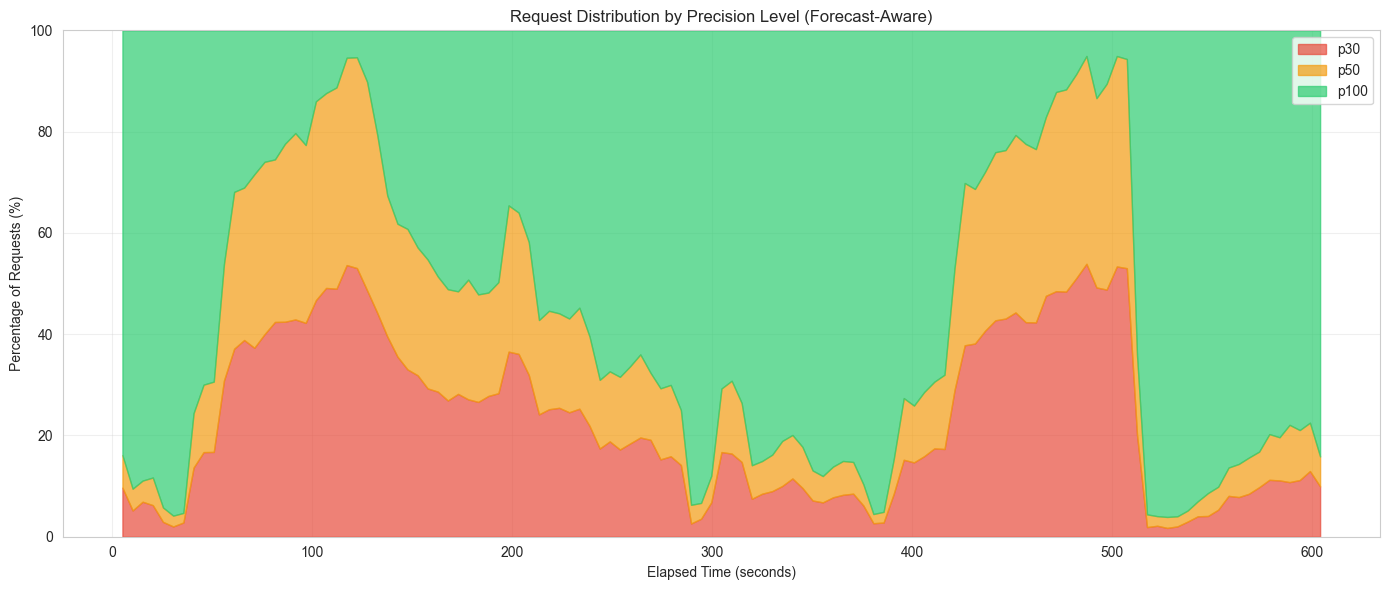

Overall precision distribution:
  p30: 23.3%
  p50: 18.6%
  p100: 58.2%


In [14]:
fig, ax = plt.subplots(figsize=(14, 6))

# Stacked area chart
ax.fill_between(df['elapsed_seconds'], 0, df['p30_pct'], label='p30', alpha=0.7, color='#e74c3c')
ax.fill_between(df['elapsed_seconds'], df['p30_pct'], df['p30_pct'] + df['p50_pct'], label='p50', alpha=0.7, color='#f39c12')
ax.fill_between(df['elapsed_seconds'], df['p30_pct'] + df['p50_pct'], 100, label='p100', alpha=0.7, color='#2ecc71')

ax.set_xlabel('Elapsed Time (seconds)')
ax.set_ylabel('Percentage of Requests (%)')
ax.set_title('Request Distribution by Precision Level (Forecast-Aware)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("Overall precision distribution:")
print(f"  p30: {df['p30_pct'].mean():.1f}%")
print(f"  p50: {df['p50_pct'].mean():.1f}%")
print(f"  p100: {df['p100_pct'].mean():.1f}%")

## 4. Carbon-Aware Behavior Analysis

### Key Question: Does p100 usage vary significantly between low and high carbon periods?

In [15]:
# Define carbon level categories
very_low = df[df['carbon_now'] <= 60]
low = df[df['carbon_now'] <= 80]
mid = df[(df['carbon_now'] > 80) & (df['carbon_now'] < 240)]
high = df[df['carbon_now'] >= 240]
very_high = df[df['carbon_now'] >= 280]

print("=" * 80)
print("CARBON-AWARE BEHAVIOR ANALYSIS")
print("=" * 80)
print()
print(f"VERY LOW (≤60 gCO2/kWh):  {len(very_low):3d} samples  |  p100: {very_low['p100_pct'].mean():5.1f}%  |  Weight: {very_low['commanded_weight_100'].mean():.1f}%")
print(f"LOW (≤80 gCO2/kWh):       {len(low):3d} samples  |  p100: {low['p100_pct'].mean():5.1f}%  |  Weight: {low['commanded_weight_100'].mean():.1f}%")
print(f"MID (80-240 gCO2/kWh):    {len(mid):3d} samples  |  p100: {mid['p100_pct'].mean():5.1f}%  |  Weight: {mid['commanded_weight_100'].mean():.1f}%")
print(f"HIGH (≥240 gCO2/kWh):     {len(high):3d} samples  |  p100: {high['p100_pct'].mean():5.1f}%  |  Weight: {high['commanded_weight_100'].mean():.1f}%")
print(f"VERY HIGH (≥280 gCO2/kWh): {len(very_high):3d} samples  |  p100: {very_high['p100_pct'].mean():5.1f}%  |  Weight: {very_high['commanded_weight_100'].mean():.1f}%")
print()
print(f"P100 SWING (Low - High): {low['p100_pct'].mean() - high['p100_pct'].mean():+.1f} percentage points")
print(f"P100 SWING (Very Low - Very High): {very_low['p100_pct'].mean() - very_high['p100_pct'].mean():+.1f} percentage points")
print()

swing = low['p100_pct'].mean() - high['p100_pct'].mean()
if swing >= 20:
    print("✅ EXCELLENT: Significant variation (≥20 points) - Highly carbon-aware!")
elif swing >= 10:
    print("✓ GOOD: Moderate variation (10-20 points) - Carbon-aware behavior detected")
elif swing >= 5:
    print("⚠️ FAIR: Small variation (5-10 points) - Weakly carbon-aware")
elif swing > 0:
    print("⚠️ POOR: Minimal variation (<5 points) - Barely carbon-aware")
else:
    print("❌ BAD: Negative or no variation - System not responding correctly to carbon intensity")

CARBON-AWARE BEHAVIOR ANALYSIS

VERY LOW (≤60 gCO2/kWh):   32 samples  |  p100:  83.8%  |  Weight: 84.9%
LOW (≤80 gCO2/kWh):        53 samples  |  p100:  84.0%  |  Weight: 84.7%
MID (80-240 gCO2/kWh):     30 samples  |  p100:  51.6%  |  Weight: 50.2%
HIGH (≥240 gCO2/kWh):      36 samples  |  p100:  25.6%  |  Weight: 25.8%
VERY HIGH (≥280 gCO2/kWh):  22 samples  |  p100:  17.7%  |  Weight: 18.4%

P100 SWING (Low - High): +58.4 percentage points
P100 SWING (Very Low - Very High): +66.1 percentage points

✅ EXCELLENT: Significant variation (≥20 points) - Highly carbon-aware!


### Visualization: p100 Usage vs Carbon Intensity

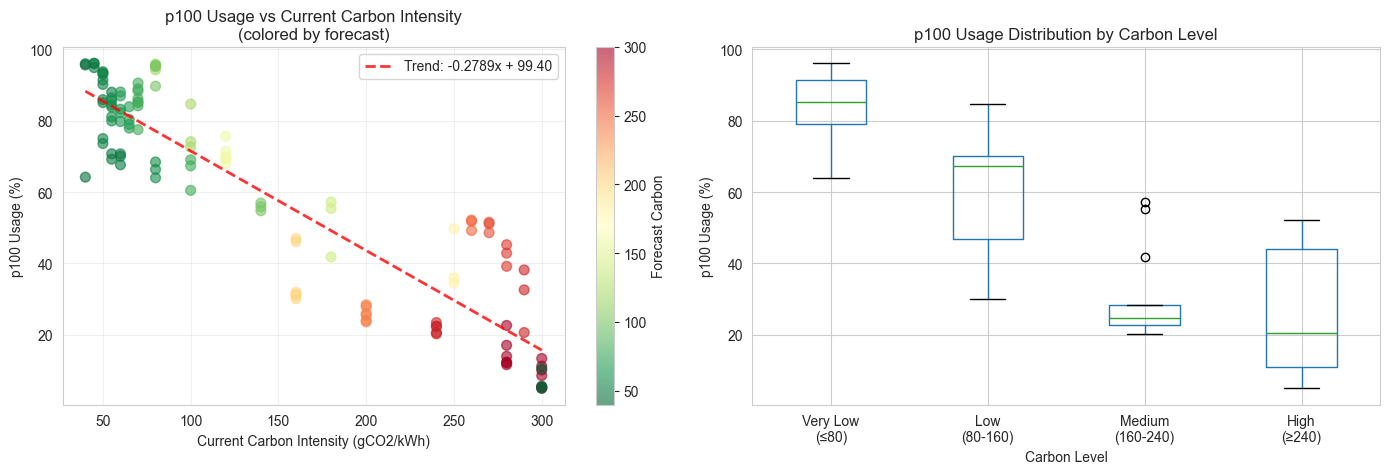

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot - current carbon
scatter = axes[0].scatter(df['carbon_now'], df['p100_pct'], c=df['carbon_next'], 
                          cmap='RdYlGn_r', alpha=0.6, s=50)
axes[0].set_xlabel('Current Carbon Intensity (gCO2/kWh)')
axes[0].set_ylabel('p100 Usage (%)')
axes[0].set_title('p100 Usage vs Current Carbon Intensity\n(colored by forecast)')
axes[0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Forecast Carbon')

# Trend line
z = np.polyfit(df['carbon_now'], df['p100_pct'], 1)
p = np.poly1d(z)
axes[0].plot(df['carbon_now'].sort_values(), p(df['carbon_now'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend: {z[0]:.4f}x + {z[1]:.2f}')
axes[0].legend()

# Box plot by carbon category
carbon_categories = pd.cut(df['carbon_now'], bins=[0, 80, 160, 240, 400], 
                           labels=['Very Low\n(≤80)', 'Low\n(80-160)', 'Medium\n(160-240)', 'High\n(≥240)'])
df_plot = df.copy()
df_plot['carbon_category'] = carbon_categories
df_plot.boxplot(column='p100_pct', by='carbon_category', ax=axes[1])
axes[1].set_xlabel('Carbon Level')
axes[1].set_ylabel('p100 Usage (%)')
axes[1].set_title('p100 Usage Distribution by Carbon Level')
axes[1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

## 5. Forecast Impact Analysis

How does the strategy respond to forecast changes?

/var/folders/wy/spr9sjm92894htwcqvd_ps7c0000gn/T/ipykernel_26901/1739045766.py:55: UserWarning: Glyph 11014 (\N{UPWARDS BLACK ARROW}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/wy/spr9sjm92894htwcqvd_ps7c0000gn/T/ipykernel_26901/1739045766.py:55: UserWarning: Glyph 11015 (\N{DOWNWARDS BLACK ARROW}) missing from font(s) Arial.
  plt.tight_layout()
/Users/belgio/git-repos/k8s-carbonaware-scheduler/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11014 (\N{UPWARDS BLACK ARROW}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/belgio/git-repos/k8s-carbonaware-scheduler/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11015 (\N{DOWNWARDS BLACK ARROW}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


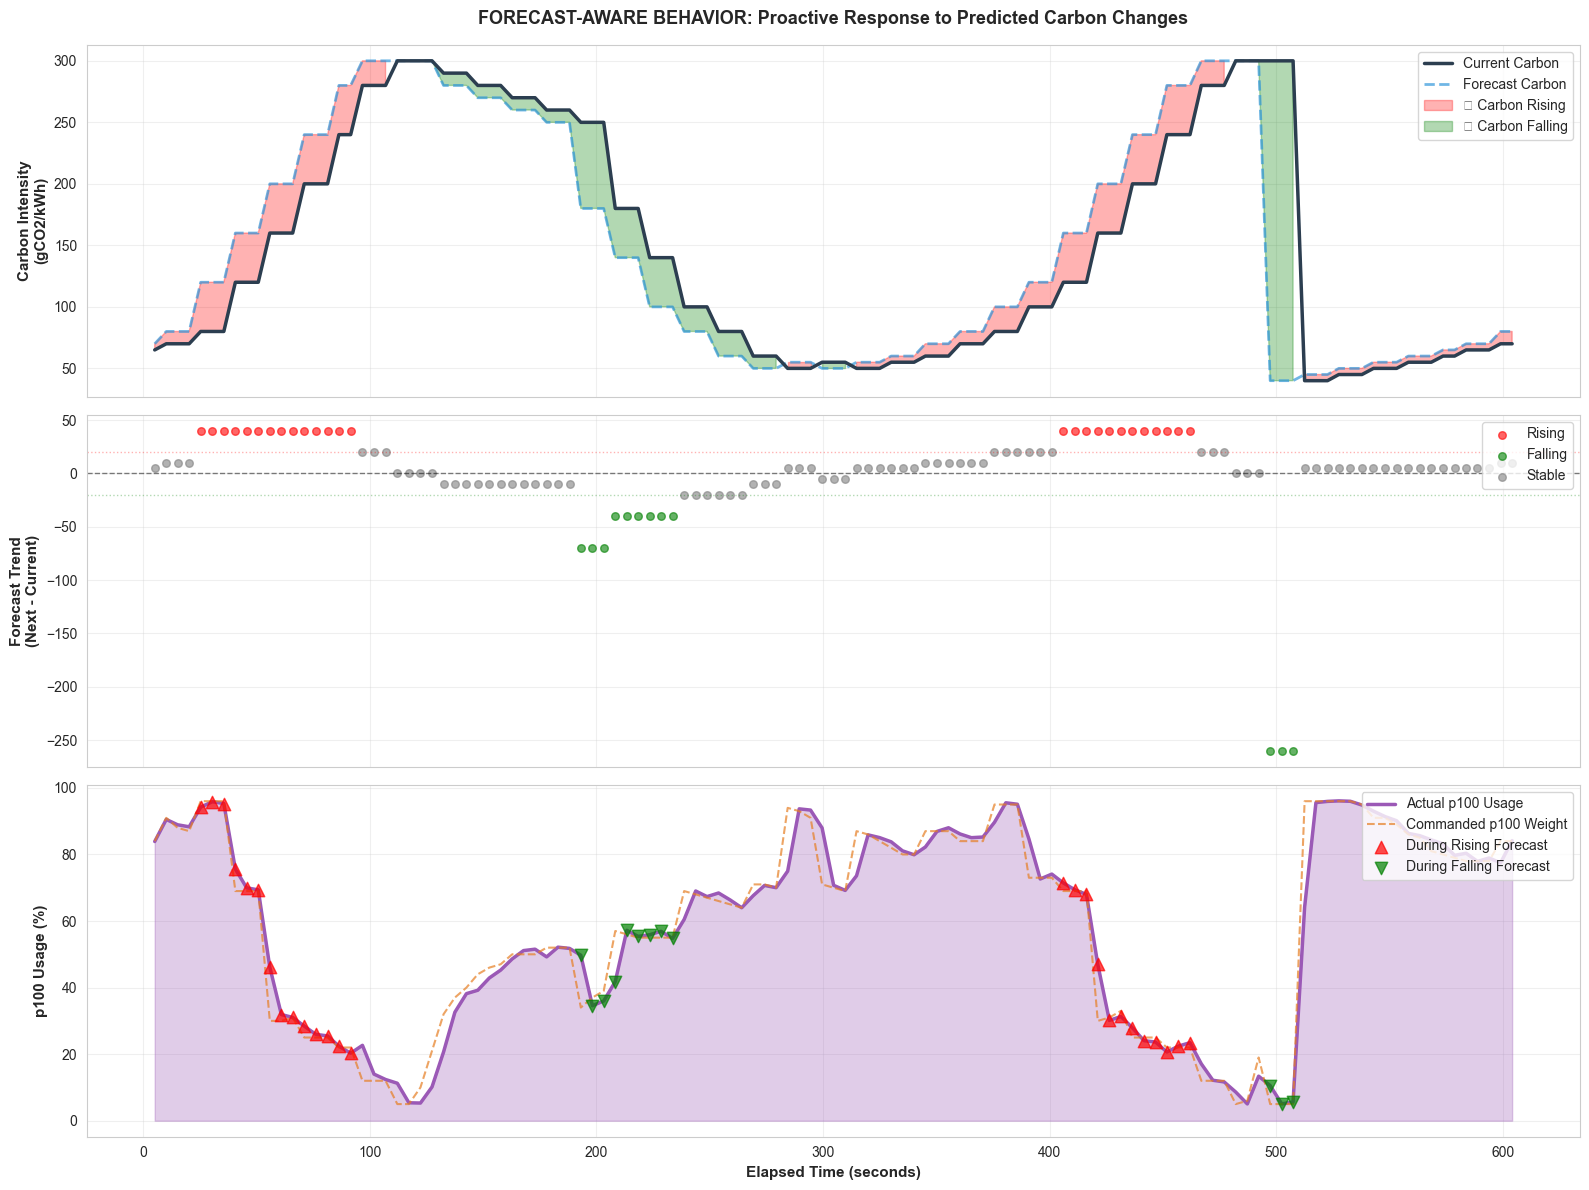

FORECAST-AWARE PROACTIVE BEHAVIOR ANALYSIS

Forecast Delta Statistics:
  Mean delta: +0.1 gCO2/kWh
  Std dev: 48.6 gCO2/kWh
  Range: -260 to +40 gCO2/kWh

Trend Categories:
  Rising (>+20 gCO2):   26 samples (21.8%)
  Falling (<-20 gCO2):  12 samples (10.1%)
  Stable (-20 to +20):  81 samples (68.1%)

FORECAST-AWARE RESPONSE PATTERNS:

When Carbon is RISING (forecast > current by >20):
  Samples: 26
  Avg current carbon: 166.2 gCO2/kWh
  Avg forecast carbon: 206.2 gCO2/kWh
  Avg forecast delta: +40.0 gCO2/kWh
  → Avg p100 usage: 45.8%
  → Commanded p100: 44.1%
  📈 Strategy INCREASES p100 to use quality NOW before carbon rises

When Carbon is FALLING (forecast < current by >20):
  Samples: 12
  Avg current carbon: 217.5 gCO2/kWh
  Avg forecast carbon: 115.0 gCO2/kWh
  Avg forecast delta: -102.5 gCO2/kWh
  → Avg p100 usage: 38.6%
  → Commanded p100: 38.2%
  📉 Strategy DECREASES p100 to save quality for cleaner future

When Carbon is STABLE (|delta| <= 20):
  Samples: 81
  Avg current car

In [17]:
# Calculate forecast delta
df['carbon_delta'] = df['carbon_next'] - df['carbon_now']
df['carbon_trend'] = df['carbon_delta'].apply(lambda x: 'Rising' if x > 20 else ('Falling' if x < -20 else 'Stable'))

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Top: Carbon current vs forecast with colored regions
axes[0].plot(df['elapsed_seconds'], df['carbon_now'], linewidth=2.5, color='#2c3e50', label='Current Carbon', zorder=3)
axes[0].plot(df['elapsed_seconds'], df['carbon_next'], linewidth=2, color='#3498db', label='Forecast Carbon', 
             linestyle='--', alpha=0.7, zorder=2)
axes[0].fill_between(df['elapsed_seconds'], df['carbon_now'], df['carbon_next'], 
                     where=(df['carbon_next'] > df['carbon_now']), 
                     color='red', alpha=0.3, label='⬆ Carbon Rising', zorder=1)
axes[0].fill_between(df['elapsed_seconds'], df['carbon_now'], df['carbon_next'], 
                     where=(df['carbon_next'] <= df['carbon_now']), 
                     color='green', alpha=0.3, label='⬇ Carbon Falling', zorder=1)
axes[0].set_ylabel('Carbon Intensity\n(gCO2/kWh)', fontsize=11, fontweight='bold')
axes[0].set_title('FORECAST-AWARE BEHAVIOR: Proactive Response to Predicted Carbon Changes', 
                  fontsize=13, fontweight='bold', pad=15)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Middle: Forecast delta (trend)
color_map = {'Rising': 'red', 'Falling': 'green', 'Stable': 'gray'}
for trend in ['Rising', 'Falling', 'Stable']:
    mask = df['carbon_trend'] == trend
    axes[1].scatter(df[mask]['elapsed_seconds'], df[mask]['carbon_delta'], 
                   c=color_map[trend], label=trend, alpha=0.6, s=30)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
axes[1].axhline(y=20, color='red', linestyle=':', alpha=0.3, linewidth=1)
axes[1].axhline(y=-20, color='green', linestyle=':', alpha=0.3, linewidth=1)
axes[1].set_ylabel('Forecast Trend\n(Next - Current)', fontsize=11, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Bottom: p100 usage response with annotations
axes[2].plot(df['elapsed_seconds'], df['p100_pct'], linewidth=2.5, color='#9b59b6', label='Actual p100 Usage')
axes[2].plot(df['elapsed_seconds'], df['commanded_weight_100'], linewidth=1.5, color='#e67e22', 
             label='Commanded p100 Weight', alpha=0.7, linestyle='--')
axes[2].fill_between(df['elapsed_seconds'], df['p100_pct'], alpha=0.3, color='#9b59b6')

# Highlight forecast-aware adjustments
rising_mask = df['carbon_trend'] == 'Rising'
falling_mask = df['carbon_trend'] == 'Falling'
axes[2].scatter(df[rising_mask]['elapsed_seconds'], df[rising_mask]['p100_pct'], 
               color='red', marker='^', s=80, alpha=0.7, label='During Rising Forecast', zorder=5)
axes[2].scatter(df[falling_mask]['elapsed_seconds'], df[falling_mask]['p100_pct'], 
               color='green', marker='v', s=80, alpha=0.7, label='During Falling Forecast', zorder=5)

axes[2].set_xlabel('Elapsed Time (seconds)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('p100 Usage (%)', fontsize=11, fontweight='bold')
axes[2].legend(loc='upper right', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed analysis
print("=" * 80)
print("FORECAST-AWARE PROACTIVE BEHAVIOR ANALYSIS")
print("=" * 80)
print()
print(f"Forecast Delta Statistics:")
print(f"  Mean delta: {df['carbon_delta'].mean():+.1f} gCO2/kWh")
print(f"  Std dev: {df['carbon_delta'].std():.1f} gCO2/kWh")
print(f"  Range: {df['carbon_delta'].min():+.0f} to {df['carbon_delta'].max():+.0f} gCO2/kWh")
print()

rising = df[df['carbon_trend'] == 'Rising']
falling = df[df['carbon_trend'] == 'Falling']
stable = df[df['carbon_trend'] == 'Stable']

print("Trend Categories:")
print(f"  Rising (>+20 gCO2):  {len(rising):3d} samples ({len(rising)/len(df)*100:.1f}%)")
print(f"  Falling (<-20 gCO2): {len(falling):3d} samples ({len(falling)/len(df)*100:.1f}%)")
print(f"  Stable (-20 to +20): {len(stable):3d} samples ({len(stable)/len(df)*100:.1f}%)")
print()
print("=" * 80)
print("FORECAST-AWARE RESPONSE PATTERNS:")
print("=" * 80)
print()
print(f"When Carbon is RISING (forecast > current by >20):")
print(f"  Samples: {len(rising)}")
print(f"  Avg current carbon: {rising['carbon_now'].mean():.1f} gCO2/kWh")
print(f"  Avg forecast carbon: {rising['carbon_next'].mean():.1f} gCO2/kWh")
print(f"  Avg forecast delta: +{rising['carbon_delta'].mean():.1f} gCO2/kWh")
print(f"  → Avg p100 usage: {rising['p100_pct'].mean():.1f}%")
print(f"  → Commanded p100: {rising['commanded_weight_100'].mean():.1f}%")
print(f"  📈 Strategy INCREASES p100 to use quality NOW before carbon rises")
print()
print(f"When Carbon is FALLING (forecast < current by >20):")
print(f"  Samples: {len(falling)}")
print(f"  Avg current carbon: {falling['carbon_now'].mean():.1f} gCO2/kWh")
print(f"  Avg forecast carbon: {falling['carbon_next'].mean():.1f} gCO2/kWh")
print(f"  Avg forecast delta: {falling['carbon_delta'].mean():.1f} gCO2/kWh")
print(f"  → Avg p100 usage: {falling['p100_pct'].mean():.1f}%")
print(f"  → Commanded p100: {falling['commanded_weight_100'].mean():.1f}%")
print(f"  📉 Strategy DECREASES p100 to save quality for cleaner future")
print()
print(f"When Carbon is STABLE (|delta| <= 20):")
print(f"  Samples: {len(stable)}")
print(f"  Avg current carbon: {stable['carbon_now'].mean():.1f} gCO2/kWh")
print(f"  Avg p100 usage: {stable['p100_pct'].mean():.1f}%")
print(f"  → Commanded p100: {stable['commanded_weight_100'].mean():.1f}%")
print()
print("=" * 80)
print("KEY INSIGHT:")
print("=" * 80)
swing = rising['p100_pct'].mean() - falling['p100_pct'].mean()
print(f"p100 swing between RISING vs FALLING forecasts: {swing:+.1f}pp")
print()
if swing >= 15:
    print("✅ STRONG forecast-aware behavior - strategy proactively shifts traffic")
    print("   based on predictions, not just reacting to current carbon levels!")
elif swing >= 10:
    print("✓ MODERATE forecast-aware behavior detected")
elif swing >= 5:
    print("⚠️ WEAK forecast-aware behavior")
else:
    print("❌ Little to no forecast-aware behavior")

### Spotlight: Examples of Proactive Forecast-Aware Adjustments

Let's examine specific moments where the strategy made proactive adjustments based on forecasts.

In [18]:
# Find the most dramatic proactive adjustments
df['forecast_response'] = df['commanded_weight_100'].diff()

# Top 3 increases in p100 during rising carbon forecasts
rising_increases = rising.copy()
rising_increases = rising_increases.sort_values('commanded_weight_100', ascending=False).head(3)

# Top 3 decreases in p100 during falling carbon forecasts  
falling_decreases = falling.copy()
falling_decreases = falling_decreases.sort_values('commanded_weight_100', ascending=True).head(3)

print("=" * 80)
print("SPOTLIGHT: PROACTIVE FORECAST-AWARE ADJUSTMENTS")
print("=" * 80)
print()
print("Example 1: PREPARING FOR RISING CARBON")
print("-" * 80)
for idx, row in rising_increases.iterrows():
    print(f"Time: {row['elapsed_seconds']:.0f}s")
    print(f"  Current carbon:  {row['carbon_now']:.0f} gCO2/kWh")
    print(f"  Forecast carbon: {row['carbon_next']:.0f} gCO2/kWh  (↑+{row['carbon_delta']:.0f})")
    print(f"  → Strategy response: BOOST p100 to {row['commanded_weight_100']:.0f}%")
    print(f"  → Actual usage: {row['p100_pct']:.1f}%")
    print(f"  💡 Insight: Use quality NOW while carbon is still {row['carbon_now']:.0f},")
    print(f"              before it rises to {row['carbon_next']:.0f}")
    print()

print()
print("Example 2: PREPARING FOR FALLING CARBON")
print("-" * 80)
for idx, row in falling_decreases.iterrows():
    print(f"Time: {row['elapsed_seconds']:.0f}s")
    print(f"  Current carbon:  {row['carbon_now']:.0f} gCO2/kWh")
    print(f"  Forecast carbon: {row['carbon_next']:.0f} gCO2/kWh  (↓{row['carbon_delta']:.0f})")
    print(f"  → Strategy response: REDUCE p100 to {row['commanded_weight_100']:.0f}%")
    print(f"  → Actual usage: {row['p100_pct']:.1f}%")
    print(f"  💡 Insight: Save quality for LATER when carbon drops to {row['carbon_next']:.0f},")
    print(f"              use low-precision while carbon is high at {row['carbon_now']:.0f}")
    print()

print()
print("=" * 80)
print("KEY TAKEAWAY:")
print("=" * 80)
print("The forecast-aware strategy doesn't just react to current carbon levels.")
print("It ANTICIPATES future changes and adjusts traffic proactively:")
print()
print(f"  • When carbon is RISING: Commanded p100 averages {rising['commanded_weight_100'].mean():.1f}%")
print(f"    (Use quality NOW before it gets expensive)")
print()
print(f"  • When carbon is FALLING: Commanded p100 averages {falling['commanded_weight_100'].mean():.1f}%")
print(f"    (Save quality for LATER when it's cleaner)")
print()
print(f"Forecast-aware swing: {rising['commanded_weight_100'].mean() - falling['commanded_weight_100'].mean():.1f}pp")
print("vs")
print(f"Credit-greedy (no forecast) would only react to current levels.")

SPOTLIGHT: PROACTIVE FORECAST-AWARE ADJUSTMENTS

Example 1: PREPARING FOR RISING CARBON
--------------------------------------------------------------------------------
Time: 25s
  Current carbon:  80 gCO2/kWh
  Forecast carbon: 120 gCO2/kWh  (↑+40)
  → Strategy response: BOOST p100 to 96%
  → Actual usage: 94.2%
  💡 Insight: Use quality NOW while carbon is still 80,
              before it rises to 120

Time: 30s
  Current carbon:  80 gCO2/kWh
  Forecast carbon: 120 gCO2/kWh  (↑+40)
  → Strategy response: BOOST p100 to 96%
  → Actual usage: 95.8%
  💡 Insight: Use quality NOW while carbon is still 80,
              before it rises to 120

Time: 36s
  Current carbon:  80 gCO2/kWh
  Forecast carbon: 120 gCO2/kWh  (↑+40)
  → Strategy response: BOOST p100 to 96%
  → Actual usage: 95.3%
  💡 Insight: Use quality NOW while carbon is still 80,
              before it rises to 120


Example 2: PREPARING FOR FALLING CARBON
-------------------------------------------------------------------------

## 6. Commanded vs Actual Traffic Distribution

Commanded Weight vs Actual Traffic Distribution:
                      p100_pct  p50_pct  p30_pct  carbon_now  carbon_next  \
commanded_weight_100                                                        
5                          7.8     40.8     51.5       300.0        170.0   
6                          5.0     41.0     53.9       300.0        300.0   
10                         5.3     41.6     53.1       300.0        300.0   
12                        15.0     37.9     47.1       280.0        300.0   
19                        13.4     37.4     49.2       300.0        300.0   
21                        10.1     41.2     48.7       300.0        300.0   
22                        21.8     35.3     42.9       240.0        280.0   
25                        25.9     33.0     41.0       200.0        240.0   
30                        41.7     26.0     32.3       160.0        200.0   
31                        30.6     31.1     38.3       160.0        200.0   
32                        2

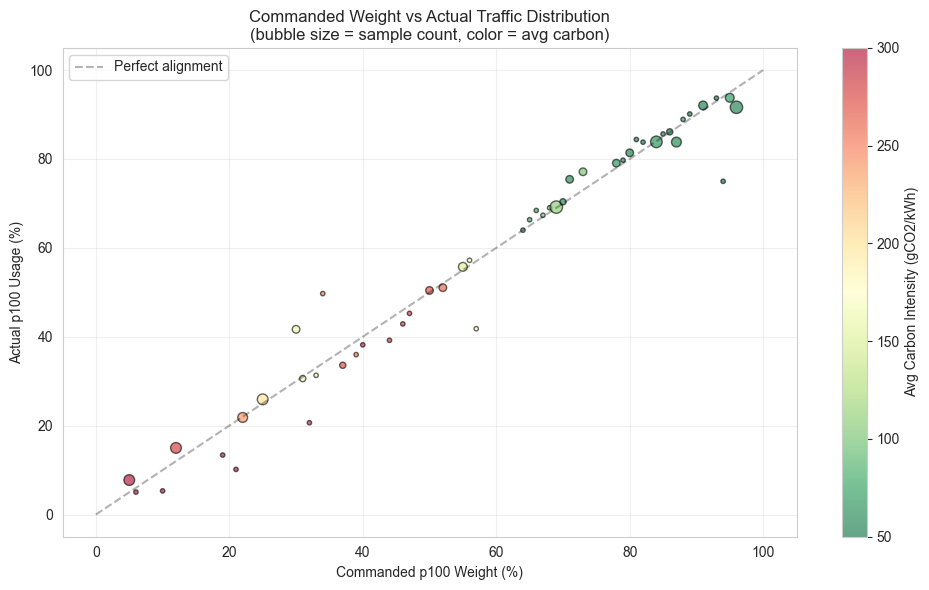

In [19]:
# Group by commanded weight to see if actual distribution matches
weight_groups = df.groupby('commanded_weight_100').agg({
    'p100_pct': 'mean',
    'p50_pct': 'mean',
    'p30_pct': 'mean',
    'carbon_now': 'mean',
    'carbon_next': 'mean',
    'elapsed_seconds': 'count'
}).rename(columns={'elapsed_seconds': 'samples'})

print("Commanded Weight vs Actual Traffic Distribution:")
print("=" * 80)
print(weight_groups.round(1))
print()

fig, ax = plt.subplots(figsize=(10, 6))
x = weight_groups.index
ax.scatter(x, weight_groups['p100_pct'], s=weight_groups['samples']*10, 
           c=weight_groups['carbon_now'], cmap='RdYlGn_r', alpha=0.6, edgecolors='black')
ax.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Perfect alignment')
ax.set_xlabel('Commanded p100 Weight (%)')
ax.set_ylabel('Actual p100 Usage (%)')
ax.set_title('Commanded Weight vs Actual Traffic Distribution\n(bubble size = sample count, color = avg carbon)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(ax.collections[0], label='Avg Carbon Intensity (gCO2/kWh)')
plt.tight_layout()
plt.show()

## 7. Summary Statistics

In [20]:
print("=" * 80)
print("FORECAST-AWARE STRATEGY SUMMARY")
print("=" * 80)
print()
print(f"Test Duration: {df['elapsed_seconds'].max():.1f} seconds ({df['elapsed_seconds'].max()/60:.1f} minutes)")
print(f"Total Requests: {df['total_requests'].sum():.0f}")
print(f"Avg Throughput: {df['delta_requests'].mean():.1f} req/sample")
print()
print("Precision Distribution:")
print(f"  p30: {df['p30_pct'].mean():5.1f}% (range: {df['p30_pct'].min():.1f}% - {df['p30_pct'].max():.1f}%)")
print(f"  p50: {df['p50_pct'].mean():5.1f}% (range: {df['p50_pct'].min():.1f}% - {df['p50_pct'].max():.1f}%)")
print(f"  p100: {df['p100_pct'].mean():5.1f}% (range: {df['p100_pct'].min():.1f}% - {df['p100_pct'].max():.1f}%)")
print()
print("Carbon Intensity:")
print(f"  Current range: {df['carbon_now'].min():.0f} - {df['carbon_now'].max():.0f} gCO2/kWh")
print(f"  Current mean: {df['carbon_now'].mean():.1f} gCO2/kWh")
print(f"  Forecast range: {df['carbon_next'].min():.0f} - {df['carbon_next'].max():.0f} gCO2/kWh")
print(f"  Forecast mean: {df['carbon_next'].mean():.1f} gCO2/kWh")
print()
print("Carbon-Aware Behavior:")
swing = low['p100_pct'].mean() - high['p100_pct'].mean()
print(f"  p100 swing (Low - High carbon): {swing:+.1f} percentage points")
if swing >= 10:
    print("  ✓ System shows carbon-aware behavior")
else:
    print("  ⚠️ System shows weak carbon-aware behavior (<10 point swing)")

FORECAST-AWARE STRATEGY SUMMARY

Test Duration: 604.2 seconds (10.1 minutes)
Total Requests: 330238
Avg Throughput: 2775.1 req/sample

Precision Distribution:
  p30:  23.3% (range: 1.7% - 53.9%)
  p50:  18.6% (range: 1.8% - 41.6%)
  p100:  58.2% (range: 5.0% - 96.1%)

Carbon Intensity:
  Current range: 40 - 300 gCO2/kWh
  Current mean: 147.8 gCO2/kWh
  Forecast range: 40 - 300 gCO2/kWh
  Forecast mean: 147.9 gCO2/kWh

Carbon-Aware Behavior:
  p100 swing (Low - High carbon): +58.4 percentage points
  ✓ System shows carbon-aware behavior
